### 机器学习练习4 - 神经网络 ###

目的：使用神经网络处理手写数字训练集  
对我意义：加深对于神经网络的实现的理解和细节理解  
实践：给代码块加上我自己的注释和总结  

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.io import loadmat #scipy的库，可以用来读取matlab格式的数据

In [2]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y=data['y']

X.shape,y.shape 

((5000, 400), (5000, 1))

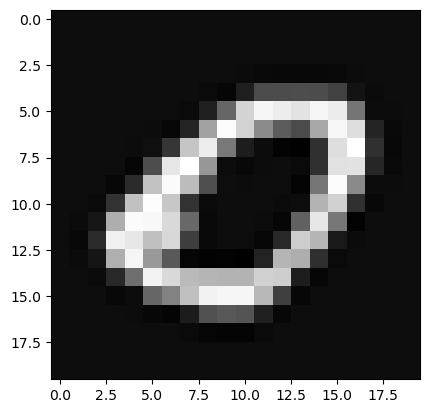

In [22]:
sample_index = 0
sample = X[sample_index,:]

image_sample = sample.reshape(20,20)

plt.imshow(image_sample,cmap='gray')
plt.show()

对于数据可以使用data['arrayname']形式获取

对于y的数据，因为我们想要做的是多类分类，所以需要将本来的列向量变成一个二维为10的矩阵数据，这里我们采用sklearn的preprocessing库的OneHotEncoder来实现

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_onehot = encoder.fit_transform(y).toarray()
y_onehot.shape

(5000, 10)

对于这个sklearn的preprocessing库的OneHotEncoder函数
效果：将本来的单值y映射到稀疏矩阵或者稠密矩阵里
使用方法:生成一个类后，调用类函数生成稀疏矩阵，用函数转换为稠密矩阵

In [5]:
y_onehot[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### 2.sigmoid函数实现 ###

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [7]:
def forward_propagate(X,theta1,theta2):
    m=X.shape[0]

    a1=np.insert(X,0,values=np.ones(m),axis=1)
    z2=a1*theta1.T
    a2=np.insert(sigmoid(z2),0,values=np.ones(m),axis=1)
    z3=a2*theta2.T
    h=sigmoid(z3)

    return a1,z2,a2,z3,h

向前传播，我认为是只有两层和书上教程的图一样，$ z_2 $表示的是对于theta1的方阵乘上x的最终结果，同理经过sigmoid处理后的a值  
经过theta2相乘得到最后一层的值再套上一层sigmoid获得结果

#### 代价函数 ####

<img style="float:left;" src="img/nn_cost.png">

In [8]:
def cost(params,input_size,hidden_size,num_labels,X,y,learning_rate):
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size +1)],(hidden_size,(input_size +1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size +1):],(num_labels,(hidden_size +1))))

    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)

    J=0
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    return J

1. 公式的复现
2. 对于将params的操作，首先是对于神经网络需要进行参数的初始化并且初始化不能为0，然后是一维的前x个和后(n-x)个reshape

In [9]:
#初始化设置
input_size = 400
hidden_size = 25
num_labels =10
learning_rate = 1

#随机初始化完成网络参数大小的参数数组(根据鱼书里面对于超参数的描述，神经网络开始theta值不能全相等为0，得随机且高斯分布)
params = (np.random.random(size=hidden_size * (input_size +1) + num_labels * (hidden_size + 1)) -0.5) * 0.25

m=X.shape[0]
X=np.matrix(X)
y=np.matrix(y)

theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size +1)],(hidden_size,(input_size +1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size +1):],(num_labels,(hidden_size +1))))

theta1.shape,theta2.shape

((25, 401), (10, 26))

In [10]:
print(X.shape)
cost(params,input_size,hidden_size,num_labels,X,y_onehot,learning_rate)

(5000, 400)


6.9716187935787906

这一段的bug还是挺多的，总结一下错误
1. 对于thete2前面的*不小心写成了.
2. 对于theta1的后面的theta2更新写成了1导致1的shape不对

### 3.正则化代价函数

对于前面的没有正则化的代价函数，现在需要添加一点类似于逻辑回归或者是线性回归的正则化项来降低高阶的影响防止过拟合

In [11]:
def cost(params,input_size,hidden_size,num_labels,X,y,learning_rate):
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size +1)],(hidden_size,(input_size +1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size +1):],(num_labels,(hidden_size +1))))

    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)

    J=0
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    #变更的地方，添加了一些正则项来防止过拟合
    J += (float(learning_rate) / (2*m)) * (np.sum(np.power(theta1[:,1:],2)) + np.sum(np.power(theta2[:,1:],2)))

    return J

类似于线性回归和逻辑回归，剔除第0项的theta后进行的累加和的平方

In [12]:
cost(params,input_size,hidden_size,num_labels,X,y_onehot,learning_rate)

6.976938419293765

In [13]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),(1-sigmoid(z)))

In [14]:
def backprop(params,input_size,hidden_size,num_labels,X,y,learning_rate):
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size +1)],(hidden_size,(input_size +1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size +1):],(num_labels,(hidden_size +1))))

    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)

    J=0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    #变更的地方，添加了一些正则项来防止过拟合
    J += (float(learning_rate) / (2*m)) * (np.sum(np.power(theta1[:,1:],2)) + np.sum(np.power(theta2[:,1:],2)))

    #反向传播添加的内容
    for t in range(m):
        #对所有数据进行切片来计算传播
        a1t=a1[t,:]
        z2t=z2[t,:]
        a2t=a2[t,:]
        ht=h[t,:]
        yt=y[t,:]

        #损失计算
        d3t = ht-yt

        #对齐theta的维度然后后面再除去
        z2t = np.insert(z2t,0,values=np.ones(1))
        d2t = np.multiply((theta2.T * d3t.T).T,sigmoid_gradient(z2t)) #链式法则加上乘法法则公式

        delta1 = delta1 + (d2t[:,1:]).T * a1t #代价函数由后向前传递
        delta2 = delta2 + d3t.T * a2t 

    delta1 = delta1 / m
    delta2 = delta2 / m

    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))

    return J,grad

In [15]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(6.976938419293765, (10285,))

对于上面的反向传播添加正则项

In [16]:
def backprop(params,input_size,hidden_size,num_labels,X,y,learning_rate):
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size +1)],(hidden_size,(input_size +1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size +1):],(num_labels,(hidden_size +1))))

    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)

    J=0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    #变更的地方，添加了一些正则项来防止过拟合
    J += (float(learning_rate) / (2*m)) * (np.sum(np.power(theta1[:,1:],2)) + np.sum(np.power(theta2[:,1:],2)))

    #反向传播添加的内容
    for t in range(m):
        #对所有数据进行切片来计算传播
        a1t=a1[t,:]
        z2t=z2[t,:]
        a2t=a2[t,:]
        ht=h[t,:]
        yt=y[t,:]

        #损失计算
        d3t = ht-yt

        #
        z2t = np.insert(z2t,0,values=np.ones(1))
        d2t = np.multiply((theta2.T * d3t.T).T,sigmoid_gradient(z2t))

        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m

    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))

    return J,grad

In [17]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(6.976938419293765, (10285,))

In [18]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='L-BFGS-B', jac=True, options={'maxiter': 250,'disp': True})
fmin

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 0.30983280611430164
        x: [-1.124e+00 -2.466e-04 ... -3.467e+00 -2.958e+00]
      nit: 250
      jac: [ 1.863e-05 -4.932e-08 ...  3.009e-05 -1.866e-06]
     nfev: 259
     njev: 259
 hess_inv: <10285x10285 LbfgsInvHessProduct with dtype=float64>

In [19]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [20]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [21]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.64%


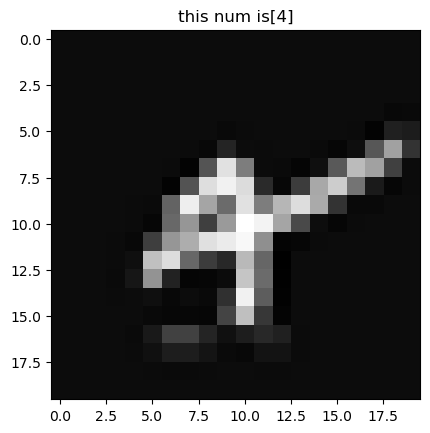

In [28]:
sample_index = 2004
sample = X[sample_index,:]

image_sample = sample.reshape(20,20)
y_pred_sample = y_pred[sample_index]

plt.imshow(image_sample,cmap='gray')
plt.title(f"this num is{y_pred_sample}")
plt.show()

好玩